In [191]:
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
from matplotlib import pyplot
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
    )

In [192]:
# Importation de la dataset
url='https://drive.google.com/file/d/1ZW5NRLx53ioZ4ogxN3NIoZJQnYeRC5Ey/view?usp=share_link'
file_id=url.split('/')[-2]
insurance='https://drive.google.com/uc?id=' + file_id
df = pd.read_csv(insurance)
data = df.copy()
data

,CODE_CONTRAT,NAT_INDIV,PAYS,SIT_PROF,DATE_EFFET,DATE_ECHEANCE,DUREE_CONTRAT,FREQ,MT_PRIME_P,TYPE_PRODUIT,DATE_RT_1,PRIME_TOTAL,NBRE_PRIME,TOTAL_RP,NBRE_RP,ETAT_CONTRAT,YEAR_BIRTH,FREQ_RP,AGE
0,ID000001,Monsieur,BENIN,COMMERCE-BUSINESS,1997-04-30,2012-03-31,15,IRREGULIER,2000000,PROD_1,1900-01-01,24400000,22,0,0,0,1970,0.000473,53
1,ID000002,Madame,BENIN,PROF LIBERALE,1997-05-30,2007-04-30,10,IRREGULIER,500000,PROD_1,1900-01-01,1500000,3,1000000,1,0,1976,0.000100,47
2,ID000003,Monsieur,BENIN,COMMERCE-BUSINESS,1997-04-30,2007-03-31,10,IRREGULIER,2000000,PROD_1,1998-03-12,2000000,1,0,0,1,1970,0.000473,53
3,ID000004,Monsieur,BENIN,COMMERCE-BUSINESS,1997-06-30,2007-05-31,10,IRREGULIER,2000000,PROD_1,2002-09-23,2000000,1,0,0,1,1970,0.000473,53
4,ID000005,Madame,BENIN,COMMERCE-BUSINESS,1997-07-31,2008-06-30,11,IRREGULIER,1000000,PROD_1,1900-01-01,1000000,1,0,0,0,1970,0.000473,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4101,ID004122,Madame,BENIN,ETUDIANT,2022-08-31,2032-07-31,10,MENSUEL,15000,PROD_5,1900-01-01,15000,1,0,0,0,1969,0.000473,54
4102,ID004123,Madame,BENIN,ETUDIANT,2022-08-31,2032-07-31,10,MENSUEL,15000,PROD_5,1900-01-01,15000,1,0,0,0,1969,0.000473,54
4103,ID004124,Monsieur,BENIN,ETUDIANT,2022-09-30,2032-08-31,10,MENSUEL,15000,PROD_5,1900-01-01,30000,2,0,0,0,1955,0.000473,68
4104,ID004125,Monsieur,BENIN,ETUDIANT,2022-10-31,2032-09-30,10,MENSUEL,15000,PROD_5,1900-01-01,15000,1,0,0,0,1959,0.000473,64


In [193]:
moy= data['NBRE_PRIME'].mean()
moy_entier = int(moy)
prime_critique = (data['NBRE_PRIME'] <= moy_entier) & (data['ETAT_CONTRAT'] == 1)
prime_critique.sum()

686

In [194]:
data['NBRE_PRIME_CRITIQUE'] = prime_critique.map({False: 0, True: 1})

In [195]:
col = data.drop('ETAT_CONTRAT', axis=1).select_dtypes(include='number').columns
col = list(col)
col

['DUREE_CONTRAT',
 'MT_PRIME_P',
 'PRIME_TOTAL',
 'NBRE_PRIME',
 'TOTAL_RP',
 'NBRE_RP',
 'YEAR_BIRTH',
 'FREQ_RP',
 'AGE',
 'NBRE_PRIME_CRITIQUE']

In [196]:
def outlier(df, col):
    list_outlier_col = col #colonnes concernées
    for i in list_outlier_col :
        #limite superieure
        upper_limit = df[i].quantile(0.95)
        #limite inferieure
        lower_limit = df[i].quantile(0.5)
        df[i] = df[i].clip(lower = lower_limit, upper =  upper_limit)
    return df

In [197]:
#data = outlier(data, col)

In [198]:
data

,CODE_CONTRAT,NAT_INDIV,PAYS,SIT_PROF,DATE_EFFET,DATE_ECHEANCE,DUREE_CONTRAT,FREQ,MT_PRIME_P,TYPE_PRODUIT,DATE_RT_1,PRIME_TOTAL,NBRE_PRIME,TOTAL_RP,NBRE_RP,ETAT_CONTRAT,YEAR_BIRTH,FREQ_RP,AGE,NBRE_PRIME_CRITIQUE
0,ID000001,Monsieur,BENIN,COMMERCE-BUSINESS,1997-04-30,2012-03-31,15,IRREGULIER,2000000,PROD_1,1900-01-01,24400000,22,0,0,0,1970,0.000473,53,0
1,ID000002,Madame,BENIN,PROF LIBERALE,1997-05-30,2007-04-30,10,IRREGULIER,500000,PROD_1,1900-01-01,1500000,3,1000000,1,0,1976,0.000100,47,0
2,ID000003,Monsieur,BENIN,COMMERCE-BUSINESS,1997-04-30,2007-03-31,10,IRREGULIER,2000000,PROD_1,1998-03-12,2000000,1,0,0,1,1970,0.000473,53,1
3,ID000004,Monsieur,BENIN,COMMERCE-BUSINESS,1997-06-30,2007-05-31,10,IRREGULIER,2000000,PROD_1,2002-09-23,2000000,1,0,0,1,1970,0.000473,53,1
4,ID000005,Madame,BENIN,COMMERCE-BUSINESS,1997-07-31,2008-06-30,11,IRREGULIER,1000000,PROD_1,1900-01-01,1000000,1,0,0,0,1970,0.000473,53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4101,ID004122,Madame,BENIN,ETUDIANT,2022-08-31,2032-07-31,10,MENSUEL,15000,PROD_5,1900-01-01,15000,1,0,0,0,1969,0.000473,54,0
4102,ID004123,Madame,BENIN,ETUDIANT,2022-08-31,2032-07-31,10,MENSUEL,15000,PROD_5,1900-01-01,15000,1,0,0,0,1969,0.000473,54,0
4103,ID004124,Monsieur,BENIN,ETUDIANT,2022-09-30,2032-08-31,10,MENSUEL,15000,PROD_5,1900-01-01,30000,2,0,0,0,1955,0.000473,68,0
4104,ID004125,Monsieur,BENIN,ETUDIANT,2022-10-31,2032-09-30,10,MENSUEL,15000,PROD_5,1900-01-01,15000,1,0,0,0,1959,0.000473,64,0


In [199]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106 entries, 0 to 4105
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_CONTRAT         4106 non-null   object 
 1   NAT_INDIV            4106 non-null   object 
 2   PAYS                 4106 non-null   object 
 3   SIT_PROF             4106 non-null   object 
 4   DATE_EFFET           4106 non-null   object 
 5   DATE_ECHEANCE        4106 non-null   object 
 6   DUREE_CONTRAT        4106 non-null   int64  
 7   FREQ                 4106 non-null   object 
 8   MT_PRIME_P           4106 non-null   int64  
 9   TYPE_PRODUIT         4106 non-null   object 
 10  DATE_RT_1            4106 non-null   object 
 11  PRIME_TOTAL          4106 non-null   int64  
 12  NBRE_PRIME           4106 non-null   int64  
 13  TOTAL_RP             4106 non-null   int64  
 14  NBRE_RP              4106 non-null   int64  
 15  ETAT_CONTRAT         4106 non-null   i

In [200]:
data['SIT_PROF'] = data['SIT_PROF'].astype('category').cat.codes
data['FREQ'] = data['FREQ'].astype('category').cat.codes
data['TYPE_PRODUIT'] = data['TYPE_PRODUIT'].astype('category').cat.codes
data['NAT_INDIV'] = data['NAT_INDIV'].astype('category').cat.codes
data['PAYS'] = data['PAYS'].astype('category').cat.codes
data['NAT_INDIV'] = data['NAT_INDIV'].astype('category').cat.codes

#data

In [201]:
#NORMALISATION

scaler = MinMaxScaler()
#data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

data['DUREE_CONTRAT'] = scaler.fit_transform(data[['DUREE_CONTRAT']])
data['MT_PRIME_P'] = scaler.fit_transform(data[['MT_PRIME_P']])
data['PRIME_TOTAL'] = scaler.fit_transform(data[['PRIME_TOTAL']])
data['NBRE_PRIME'] = scaler.fit_transform(data[['NBRE_PRIME']])
data['YEAR_BIRTH'] = scaler.fit_transform(data[['YEAR_BIRTH']])
data['TOTAL_RP'] = scaler.fit_transform(data[['TOTAL_RP']])
data['AGE'] = scaler.fit_transform(data[['AGE']])

#data

In [202]:
data

,CODE_CONTRAT,NAT_INDIV,PAYS,SIT_PROF,DATE_EFFET,DATE_ECHEANCE,DUREE_CONTRAT,FREQ,MT_PRIME_P,TYPE_PRODUIT,DATE_RT_1,PRIME_TOTAL,NBRE_PRIME,TOTAL_RP,NBRE_RP,ETAT_CONTRAT,YEAR_BIRTH,FREQ_RP,AGE,NBRE_PRIME_CRITIQUE
0,ID000001,4,0,4,1997-04-30,2012-03-31,0.344828,1,0.024817,0,1900-01-01,0.305000,0.098214,0.000000,0,0,0.390244,0.000473,0.609756,0
1,ID000002,3,0,14,1997-05-30,2007-04-30,0.172414,1,0.006064,0,1900-01-01,0.018750,0.013393,0.014286,1,0,0.463415,0.000100,0.536585,0
2,ID000003,4,0,4,1997-04-30,2007-03-31,0.172414,1,0.024817,0,1998-03-12,0.025000,0.004464,0.000000,0,1,0.390244,0.000473,0.609756,1
3,ID000004,4,0,4,1997-06-30,2007-05-31,0.172414,1,0.024817,0,2002-09-23,0.025000,0.004464,0.000000,0,1,0.390244,0.000473,0.609756,1
4,ID000005,3,0,4,1997-07-31,2008-06-30,0.206897,1,0.012315,0,1900-01-01,0.012500,0.004464,0.000000,0,0,0.390244,0.000473,0.609756,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4101,ID004122,3,0,10,2022-08-31,2032-07-31,0.172414,2,0.000000,4,1900-01-01,0.000188,0.004464,0.000000,0,0,0.378049,0.000473,0.621951,0
4102,ID004123,3,0,10,2022-08-31,2032-07-31,0.172414,2,0.000000,4,1900-01-01,0.000188,0.004464,0.000000,0,0,0.378049,0.000473,0.621951,0
4103,ID004124,4,0,10,2022-09-30,2032-08-31,0.172414,2,0.000000,4,1900-01-01,0.000375,0.008929,0.000000,0,0,0.207317,0.000473,0.792683,0
4104,ID004125,4,0,10,2022-10-31,2032-09-30,0.172414,2,0.000000,4,1900-01-01,0.000188,0.004464,0.000000,0,0,0.256098,0.000473,0.743902,0


In [203]:
data = data.drop(['AGE','TYPE_PRODUIT','FREQ_RP','YEAR_BIRTH','FREQ','PAYS','DATE_EFFET','DATE_ECHEANCE','DATE_RT_1','NAT_INDIV','CODE_CONTRAT'], axis=1)
data

,SIT_PROF,DUREE_CONTRAT,MT_PRIME_P,PRIME_TOTAL,NBRE_PRIME,TOTAL_RP,NBRE_RP,ETAT_CONTRAT,NBRE_PRIME_CRITIQUE
0,4,0.344828,0.024817,0.305000,0.098214,0.000000,0,0,0
1,14,0.172414,0.006064,0.018750,0.013393,0.014286,1,0,0
2,4,0.172414,0.024817,0.025000,0.004464,0.000000,0,1,1
3,4,0.172414,0.024817,0.025000,0.004464,0.000000,0,1,1
4,4,0.206897,0.012315,0.012500,0.004464,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...
4101,10,0.172414,0.000000,0.000188,0.004464,0.000000,0,0,0
4102,10,0.172414,0.000000,0.000188,0.004464,0.000000,0,0,0
4103,10,0.172414,0.000000,0.000375,0.008929,0.000000,0,0,0
4104,10,0.172414,0.000000,0.000188,0.004464,0.000000,0,0,0


In [204]:
#data=data.set_index("CODE_CONTRAT")
#data

In [205]:
#data_with_get_dummies = data.copy()
#data_with_ohe = data.copy()
#data = pd.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=['SIT_PROF'], sparse=False, drop_first=False, dtype=None)

In [206]:
#data_with_get_dummies

In [207]:
data

,SIT_PROF,DUREE_CONTRAT,MT_PRIME_P,PRIME_TOTAL,NBRE_PRIME,TOTAL_RP,NBRE_RP,ETAT_CONTRAT,NBRE_PRIME_CRITIQUE
0,4,0.344828,0.024817,0.305000,0.098214,0.000000,0,0,0
1,14,0.172414,0.006064,0.018750,0.013393,0.014286,1,0,0
2,4,0.172414,0.024817,0.025000,0.004464,0.000000,0,1,1
3,4,0.172414,0.024817,0.025000,0.004464,0.000000,0,1,1
4,4,0.206897,0.012315,0.012500,0.004464,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...
4101,10,0.172414,0.000000,0.000188,0.004464,0.000000,0,0,0
4102,10,0.172414,0.000000,0.000188,0.004464,0.000000,0,0,0
4103,10,0.172414,0.000000,0.000375,0.008929,0.000000,0,0,0
4104,10,0.172414,0.000000,0.000188,0.004464,0.000000,0,0,0


In [208]:
x = data.drop(columns='ETAT_CONTRAT', axis=1)
y = data['ETAT_CONTRAT']

In [209]:
#Partage en données d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify=y, random_state = 1)

print("Nombre de données d'entraînement :", len(X_train))
print("Nombre de données de test :", len(X_test))

Nombre de données d'entraînement : 3284
Nombre de données de test : 822


# RANDOM FOREST

In [218]:
model_rf = RandomForestClassifier(n_jobs=-1, n_estimators=341, min_samples_split=6, min_samples_leaf= 6, max_features='sqrt', max_depth=20, criterion='entropy', random_state=123)

In [219]:
# Entraînement du modèle sur les données d'entraînement
model_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=6,
                       min_samples_split=6, n_estimators=341, n_jobs=-1,
                       random_state=123)

In [220]:
pred = model_rf.predict(X_test)

In [221]:
from sklearn import metrics
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       569
           1       0.89      0.81      0.85       253

    accuracy                           0.91       822
   macro avg       0.90      0.88      0.89       822
weighted avg       0.91      0.91      0.91       822



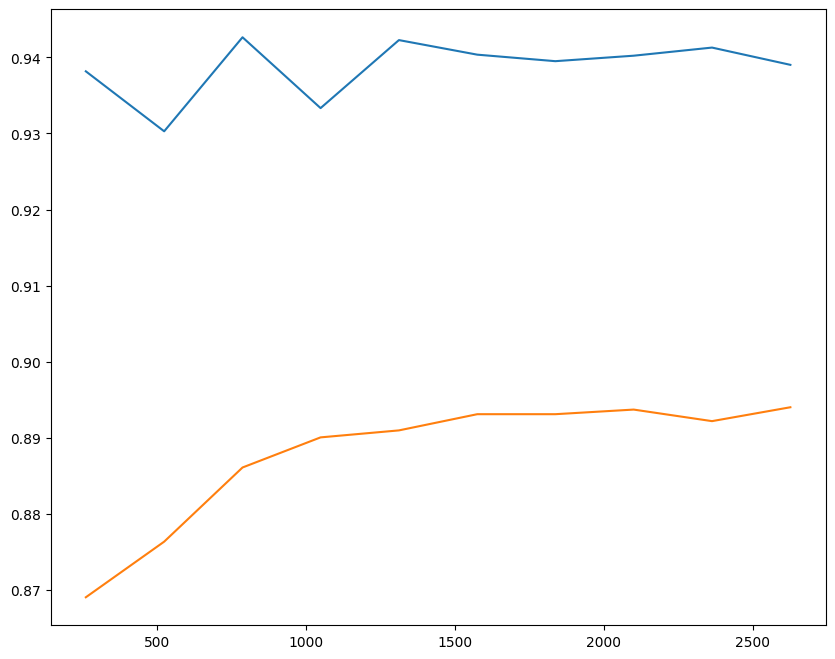

In [ ]:
Echan, train_score, val_score=learning_curve(model_rf, X_train,y_train, cv=5, train_sizes=np.linspace(0.1,1,10))
plt.figure(figsize=(10,8))
plt.plot(Echan, train_score.mean(axis=1),label='Entrainement')
plt.plot(Echan, val_score.mean(axis=1),label='validation')

In [ ]:
pd.crosstab(y_test,pred)

col_0,0,1
ETAT_CONTRAT,,
0,541,28
1,50,203


In [ ]:
#from sklearn.tree import plot_feature_importances

importances = model_rf.feature_importances_
print(importances)

[0.10818913 0.03268213 0.11755709 0.15415309 0.27743751 0.06962728
 0.04346912 0.10222903 0.         0.09465562]


In [ ]:
#Fonction pour afficher les variables ayant une importance relative supérieure à 5% et renvoyer celles dont l'importance relative inférieure à 5%
list_var_non_important=[]

def var_import(model):
  print('Les variables ayant une importance relative supérieure à 5%')
  for feature_name, feature_importance in zip(model.feature_names_in_, model.feature_importances_):
    if feature_importance*100>=0:
      print(f'{feature_name} : {feature_importance*100}')
    else:
      list_var_non_important.append(feature_name)
  return list_var_non_important

In [ ]:
var_import(model_rf)

Les variables ayant une importance relative supérieure à 5%
SIT_PROF : 3.0594587584591415
DUREE_CONTRAT : 1.3395991916387686
MT_PRIME_P : 3.5585333639445036
TYPE_PRODUIT : 0.5256586311186057
PRIME_TOTAL : 13.15065804451619
NBRE_PRIME : 22.003921597447967
TOTAL_RP : 2.230236440235698
NBRE_RP : 0.902718537729567
AGE : 3.6022839162818254
NBRE_PRIME_CRITIQUE : 49.62693151862773


[]

## Optimisation des hyperparamètres

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.2 MB/s eta 0:00:00


In [ ]:
model1 = RandomForestClassifier(random_state=10)

# Définition d'une grille de paramètres
params = {
    'criterion': ['entropy', 'gini'],
    'n_estimators':[10, 100, 500, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf':[2,4,6,8,10],
    'min_samples_split':[2,4,6,8,10],
    'max_features': ['sqrt', 'log2', None]
    }

In [ ]:
# Création d'un objet de recherche aléatoire sur grille de paramètres
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#from skopt import BayesSearchCV

model_rf1 = RandomizedSearchCV(
    estimator=model1,
    param_distributions=params,
    n_iter=10,
    cv=5,
    random_state=10
)

In [ ]:
# Entraînement du modèle avec la recherche aléatoire sur grille de paramètres
model_rf1.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 100, 500, 1000]},
                   random_state=10)

In [ ]:
# Affichage des meilleurs paramètres trouvés et du score associé
print('Meilleurs paramètres:', model_rf1.best_params_)
print('Meilleur score R2:', model_rf1.best_score_)

Meilleurs paramètres: {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}
Meilleur score R2: 0.8946398076994468


In [ ]:
params_grid = {
    'n_estimators': [100, 200, 500, 700, 1000],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2,4,6,8,10],
    'min_samples_leaf': [2,4,6,8,10],
    'max_leaf_nodes': [4,10,20,50,None]
}

In [ ]:
model_rf_grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params_grid, n_jobs=-1, cv=KFold(n_splits=3), scoring='accuracy')
model_rf_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_leaf_nodes': [4, 10, 20, 50, None],
                         'min_samples_leaf': [2, 4, 6, 8, 10],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 200, 500, 700, 1000]},
             scoring='accuracy')

In [ ]:
print('Best score:', model_rf_grid.best_score_)
print('Best score:', model_rf_grid.best_params_)

Best score: 0.7512178148921365
Best score: {'criterion': 'gini', 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 500}


# XGBOOST

In [69]:
model_xgb = XGBClassifier(  )

In [70]:
# Entraînement du modèle sur les données d'entraînement
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [72]:
pred_xgb = model_xgb.predict(X_test)

In [73]:
from sklearn import metrics
print(metrics.classification_report(y_test,pred_xgb))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       569
           1       0.87      0.84      0.85       253

    accuracy                           0.91       822
   macro avg       0.90      0.89      0.89       822
weighted avg       0.91      0.91      0.91       822



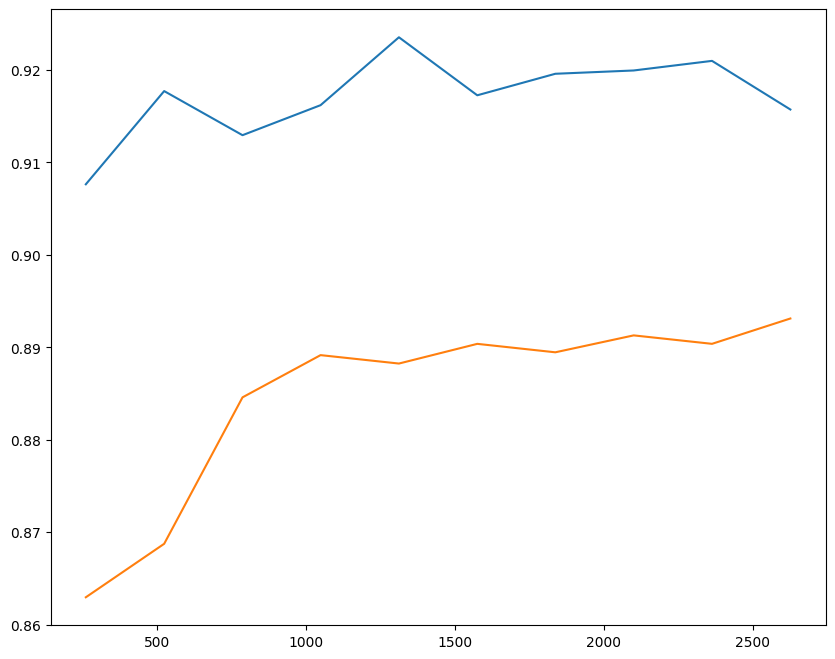

In [74]:
Echan, train_score, val_score=learning_curve(model_xgb, X_train,y_train, cv=5, train_sizes=np.linspace(0.1,1,10))
plt.figure(figsize=(10,8))
plt.plot(Echan, train_score.mean(axis=1),label='Entrainement')
plt.plot(Echan, val_score.mean(axis=1),label='validation')

In [75]:
pd.crosstab(y_test,pred_xgb)

col_0,0,1
ETAT_CONTRAT,,
0,537,32
1,41,212


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

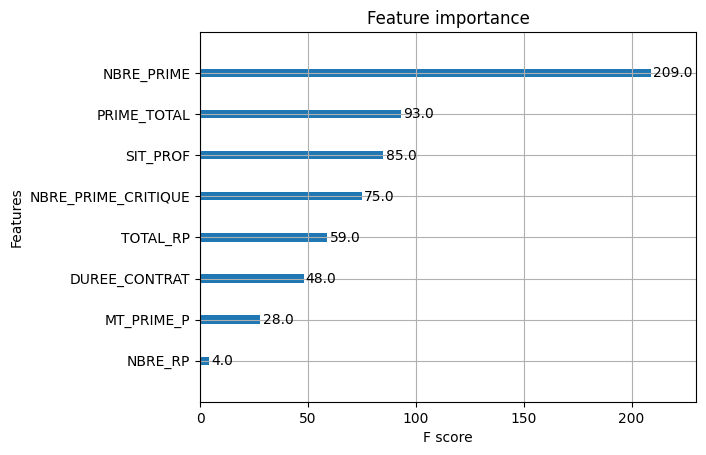

In [76]:
xgb.plot_importance(model_xgb)

## Optimisation des hyperparamètres

In [ ]:
# XGBoost roc_auc
# n_jobs=-1 to allow run it on all cores
params_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

In [ ]:
model_xgb_optimal = GridSearchCV(XGBClassifier(n_jobs=-1), params_xgb, n_jobs=-1, cv=KFold(n_splits=3), scoring='accuracy')
model_xgb_optimal.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1458 fits failed out of a total of 4374.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
92 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.9/dist-packages/xgboost/core.py", line 620, in inner_f
   

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'base_score': [0.2, 0.5, 1],
                         'booster': ['gbtree', 'gblinear'],
                         'gamma': [0, 0.5, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 500],
                         'reg_alpha': [0, 0.5, 1], 'reg_lambda': [0.5, 1, 5]},
             scoring='accuracy')

In [72]:
print('Best score:', model_xgb_optimal.best_score_)
print('Best score:', model_xgb_optimal.best_params_)

Best score: 0.8970769021005679
Best score: {'base_score': 0.5, 'booster': 'gbtree', 'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 5}


# KNN

In [109]:
model_knn = KNeighborsClassifier(algorithm = 'auto', leaf_size= 5, metric= 'manhattan', n_neighbors= 11, p= 2, weights= 'uniform')

In [110]:
# Entraînement du modèle sur les données d'entraînement
model_knn.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=5, metric='manhattan', n_neighbors=11)

In [113]:
pred_knn = model_knn.predict(X_test)

In [114]:
from sklearn import metrics
print(metrics.classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       569
           1       0.83      0.81      0.82       253

    accuracy                           0.89       822
   macro avg       0.87      0.87      0.87       822
weighted avg       0.89      0.89      0.89       822



In [81]:
pd.crosstab(y_test,pred_knn)

col_0,0,1
ETAT_CONTRAT,,
0,530,39
1,56,197


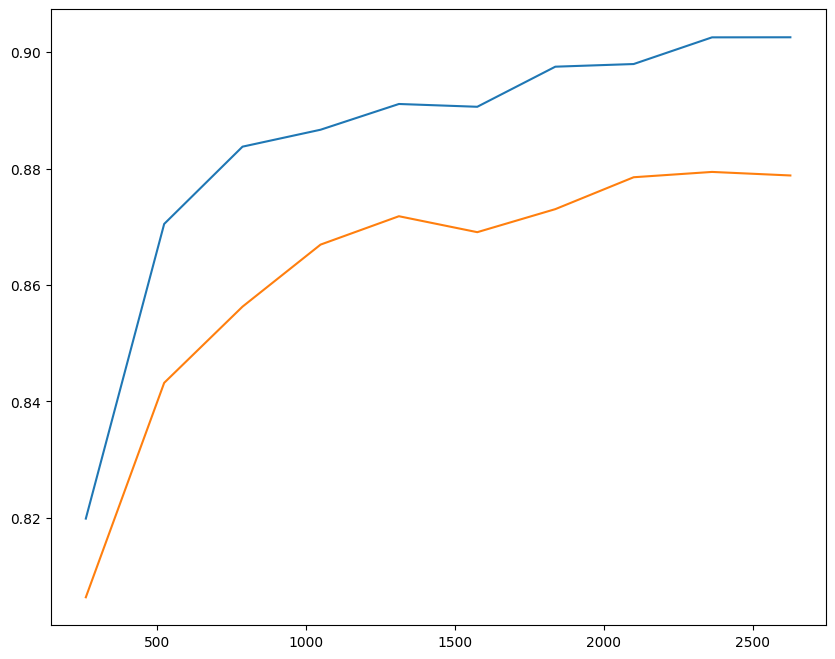

In [82]:
Echan, train_score, val_score=learning_curve(model_knn, X_train,y_train, cv=5, train_sizes=np.linspace(0.1,1,10))
plt.figure(figsize=(10,8))
plt.plot(Echan, train_score.mean(axis=1),label='Entrainement')
plt.plot(Echan, val_score.mean(axis=1),label='validation')

In [99]:
model_knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 12,
 'p': 2,
 'weights': 'uniform'}

## Optimisation des Hp

In [116]:
params_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan', 'chebyshev','minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'leaf_size': [5,10,15,20,30],
    'p': [2,4,6,8,9,10],
    'weights': ['uniform', 'distance']
}

In [117]:
model_knn_optimal = GridSearchCV(KNeighborsClassifier(n_jobs=-1), params_knn, n_jobs=-1, cv=KFold(n_splits=3), scoring='accuracy')
model_knn_optimal.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'leaf_size': [5, 10, 15, 20, 30],
                         'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'p': [2, 4, 6, 8, 9, 10],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [108]:
print('Best score:', model_knn_optimal.best_score_)
print('Best score:', model_knn_optimal.best_params_)

Best score: 0.954333074057606
Best score: {'algorithm': 'auto', 'leaf_size': 5, 'metric': 'manhattan', 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}


# REGRESSION LOGISTIQUE

In [83]:
model_rl = LogisticRegression()

In [84]:
# Entraînement du modèle sur les données d'entraînement
model_rl.fit(X_train, y_train)

LogisticRegression()

In [85]:
pred_rl = model_rl.predict(X_test)

In [223]:
model_rl.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [87]:
from sklearn import metrics
print(metrics.classification_report(y_test,pred_rl))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       569
           1       0.94      0.58      0.71       253

    accuracy                           0.86       822
   macro avg       0.89      0.78      0.81       822
weighted avg       0.87      0.86      0.85       822



In [88]:
pd.crosstab(y_test,pred_rl)

col_0,0,1
ETAT_CONTRAT,,
0,559,10
1,107,146


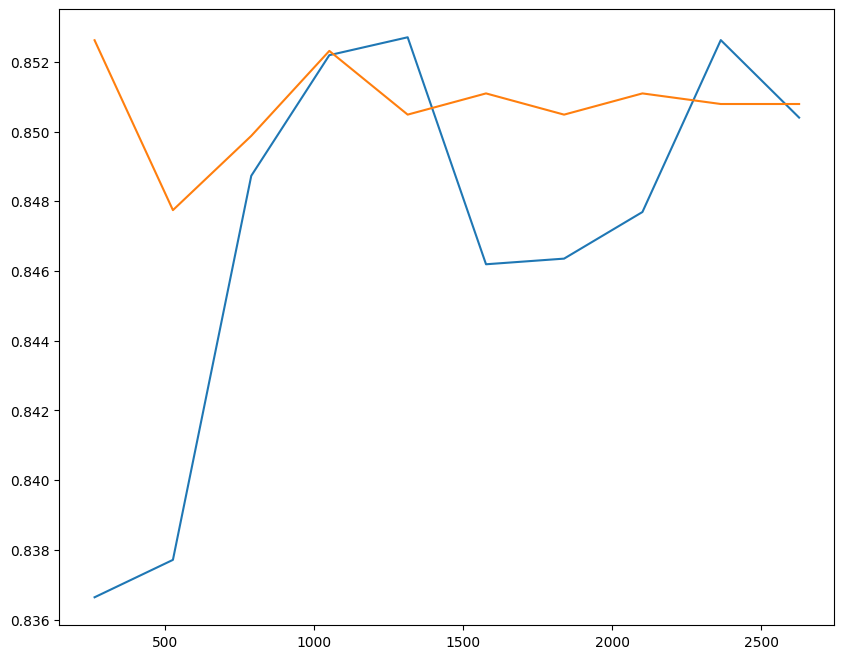

In [89]:
Echan, train_score, val_score=learning_curve(model_rl, X_train,y_train, cv=5, train_sizes=np.linspace(0.1,1,10))
plt.figure(figsize=(10,8))
plt.plot(Echan, train_score.mean(axis=1),label='Entrainement')
plt.plot(Echan, val_score.mean(axis=1),label='validation')

## Optimisation des Hp

In [227]:
model_rl.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [228]:
params_rl = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'dual': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'intercept_scaling': [0.1, 0.5, 1, 2],
    'class_weight': [None, 'balanced'],
    'random_state': [42],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 200],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'verbose': [0, 1, 2],
    'warm_start': [True, False],
    'n_jobs': [None, -1],
    'l1_ratio': [0.1, 0.5, 0.9]
}

In [ ]:
model_rl_optimal = GridSearchCV(LogisticRegression(n_jobs=-1), params_rl, n_jobs=-1, cv=KFold(n_splits=2), scoring='accuracy')
model_rl_optimal.fit(X_train, y_train)

In [226]:
print('Best score:', model_rl_optimal.best_score_)
print('Best score:', model_rl_optimal.best_params_)

Best score: 0.8596224116930573
Best score: {'C': 0.1, 'class_weight': None, 'fit_intercept': False, 'intercept_scaling': 0.1, 'max_iter': 50, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}


# ARBRE DE DECISION

In [90]:
model_tree = DecisionTreeClassifier()

In [91]:
# Entraînement du modèle sur les données d'entraînement
model_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [92]:
pred_tree = model_tree.predict(X_test)

In [93]:
from sklearn import metrics
print(metrics.classification_report(y_test,pred_tree))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       569
           1       0.80      0.80      0.80       253

    accuracy                           0.88       822
   macro avg       0.86      0.86      0.86       822
weighted avg       0.88      0.88      0.88       822



In [94]:
pd.crosstab(y_test,pred_tree)

col_0,0,1
ETAT_CONTRAT,,
0,518,51
1,50,203


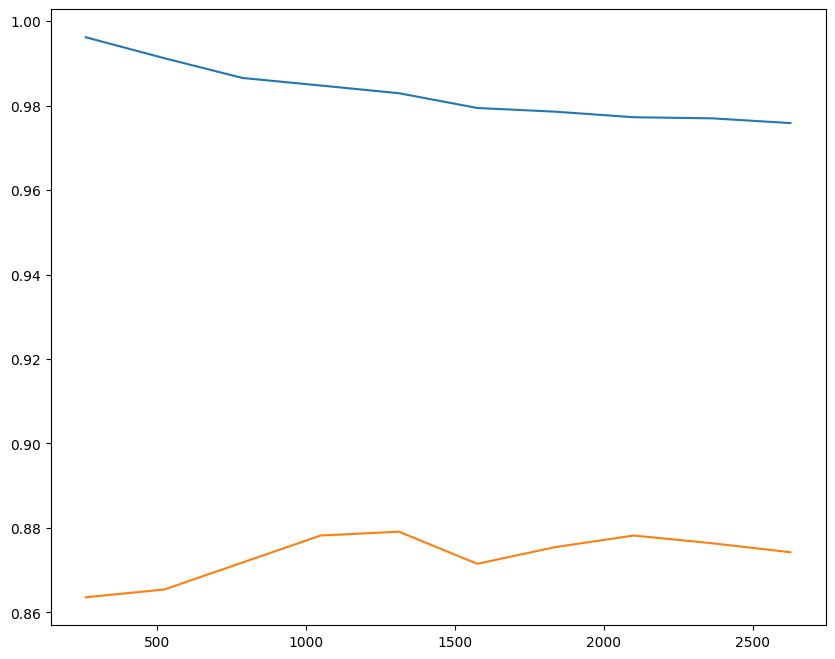

In [95]:
Echan, train_score, val_score=learning_curve(model_tree, X_train,y_train, cv=5, train_sizes=np.linspace(0.1,1,10))
plt.figure(figsize=(10,8))
plt.plot(Echan, train_score.mean(axis=1),label='Entrainement')
plt.plot(Echan, val_score.mean(axis=1),label='validation')

## Optimisation des Hp

In [ ]:
params_tree = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [42]
}

In [ ]:
model_tree_optimal = GridSearchCV(DecisionTreeClassifier(), params_tree, cv=5)
model_tree_optimal.fit(X_train, y_train)

In [ ]:
print('Best score:', model_tree_optimal.best_score_)
print('Best score:', model_tree_optimal.best_params_)